C:\Users\lanto\AppData\Local\Temp\ipykernel_17452\1907668990.py:87: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(residual, u0)


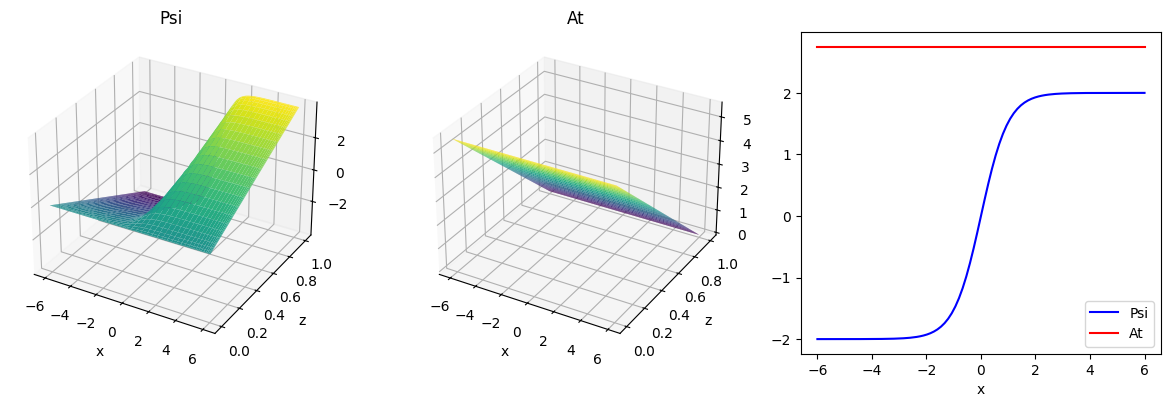

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve

# 定义参数
mu = 5.5
m = 25
n = 141
L = 6.0

# 定义函数 f(w) 及其导数
def f(w):
    return 1 - w**3

def fp(w):
    return -3 * w**2

# 生成 Chebyshev-Gauss-Lobatto 节点
y1 = np.cos(np.pi * np.arange(m) / (m - 1))  # z 方向
y2 = np.cos(np.pi * np.arange(n) / (n - 1))  # x 方向

# 生成 Chebyshev 微分矩阵的系数
c1 = np.ones(m)
c1[0] = 2.0
c1[-1] = 2.0

c2 = np.ones(n)
c2[0] = 2.0
c2[-1] = 2.0

# 计算 z 方向的微分矩阵 dz
dz = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        if i != j:
            dz[i, j] = c1[i] / c1[j] * (-1)**(i + j) / (y1[i] - y1[j])
dz -= np.diag(np.sum(dz, axis=1))

# 计算 x 方向的微分矩阵 dx
dx = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            dx[i, j] = c2[i] / c2[j] * (-1)**(i + j) / (y2[i] - y2[j])
dx -= np.diag(np.sum(dx, axis=1))
dx = dx.T

# 计算二阶微分矩阵
d2z = np.dot(dz, dz)
d2x = np.dot(dx, dx)

# 计算物理空间中的坐标
z = (1 + y1) / 2
x = L * y2

# 计算函数 f(z) 及其导数在网格点上的值
fz = f(z)
fpz = fp(z)

# 初始化场变量 Psi 和 A
Psi = np.zeros((m, n))
At = np.zeros((m, n))

# 定义残差函数
def residual(u):
    Psi = u[:m * n].reshape((m, n))
    At = u[m * n:].reshape((m, n))

    RPsi = (z[:, None] - At**2) * Psi - np.dot(Psi, d2x) + 3 * z[:, None]**2 * np.dot(dz, Psi) - fz[:, None] * np.dot(d2z, Psi)
    RAt = -fz[:, None] * np.dot(d2z, At) + 3 * z[:, None]**2 * np.dot(dz, At) - np.dot(At, d2x) + (2 * Psi**2) * At

    # 边界条件
    RPsi[-1, :] = Psi[-1, :]
    RPsi[:, 0] = np.dot(Psi, dx[:, 0])
    RPsi[:, -1] = np.dot(Psi, dx[:, -1])
    RAt[-1, :] = At[-1, :] - mu
    RAt[:, 0] = np.dot(At, dx[:, 0])
    RAt[:, -1] = np.dot(At, dx[:, -1])

    return np.concatenate((RPsi.flatten(), RAt.flatten()))

# 设置初始猜测值
u0 = np.concatenate((4 * np.outer(z, np.tanh(x)).flatten(), mu * np.outer(1 - z, np.ones(n)).flatten()))

# 使用 fsolve 求解方程组
sol = fsolve(residual, u0)

# 获取解
Psi = sol[:m * n].reshape((m, n))
At = sol[m * n:].reshape((m, n))

# 绘制结果
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
X, Z = np.meshgrid(x, z)
ax1.plot_surface(X, Z, Psi, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax1.set_title('Psi')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X, Z, At, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_title('At')

ax3 = fig.add_subplot(133)
ax3.plot(x, np.dot(dz[-1, :], Psi), 'b-', label='Psi')
ax3.plot(x, -np.dot(dz[-1, :], At), 'r-', label='At')
ax3.set_xlabel('x')
ax3.legend()

plt.tight_layout()
plt.show()